In [1]:
# TODO remove
import sys

# --- The APIs that are being highlighed ---

# the main API for loading / saving tables, running BQL queries, returns cursor objects
import bayeslite

# pretty printing tables to screen (can take cursors as input)
import bayeslite.shell.pretty as pretty

# plotting
from bdbcontrib import plotutils
# TODO once fsaad is done use instead: from bdbcontrib import contrib_plot
# importing contrib_plot currently fails with 'No current shell!' error.

# ipython notebook will generate plots inline given a fig object.
import matplotlib.pyplot as plt
%matplotlib inline

# other utilities
from bdbcontrib import general_utils # conttains???
from bdbcontrib import bql_utils  # contains cursor_to_df
# TODO once fsaad is done use instead: from bdbcontrib import contrib_util
# importing general_utils currently fails with 'No current shell!' error.

Introduction
=====
In this example we will explore the core functionality of BayesDB by using BayesDB to explore and analyze some real data. The data we will use is the Union of Concerned Scientists' Satellites data. The data is a catalogue of satellites. Each row of the data represents a satellite and each column is a feature of that satellite such as dry mass, orbit type, launch date, perigee, etc.

Loading the Bayesian Database
=====
We first open our Bayesian database that contains the Bayesian model of the satellites data. This database resides on disk in the form of a `.bdb` file.

In [2]:
satellites_bdb = bayeslite.bayesdb_open(pathname='satellites4.bdb')
bayeslite.bayesdb_read_csv_file(satellites_bdb, "satellites", "satellites.utf8.csv", 
                                header=True, create=True, ifnotexists=True)

import crosscat.LocalEngine
import bayeslite.crosscat
crosscat_engine = crosscat.LocalEngine.LocalEngine(seed=0)
crosscat_metamodel = bayeslite.crosscat.CrosscatMetamodel(crosscat_engine)
bayeslite.bayesdb_register_metamodel(satellites_bdb, crosscat_metamodel)

# TODO load from .bdb instead
satellites_bdb.execute('create generator satellites_cc for satellites using crosscat(guess(*))')
satellites_bdb.execute('initialize 4 models for satellites_cc')
satellites_bdb.execute('analyze satellites_cc for 2 iterations wait')

In [15]:
pretty.pp_cursor(sys.stdout, satellites_bdb.execute('''
SELECT * from bayesdb_generator
'''))
pretty.pp_cursor(sys.stdout, satellites_bdb.execute('''
SELECT * from bayesdb_column
'''))
pretty.pp_cursor(sys.stdout, satellites_bdb.execute('''
SELECT * from bayesdb_generator_column
'''))
#pretty.pp_cursor(sys.stdout, satellites_bdb.sql_execute('PRAGMA table_info(satellites)'))

id |          name |    tabname | metamodel | defaultp
---+---------------+------------+-----------+---------
 1 | satellites_cc | satellites |  crosscat |        0
   tabname | colno |                         name | shortname | description
-----------+-------+------------------------------+-----------+------------
satellites |     0 |                         Name |      None |        None
satellites |     1 |          Country_of_Operator |      None |        None
satellites |     2 |               Operator_Owner |      None |        None
satellites |     3 |                        Users |      None |        None
satellites |     4 |                      Purpose |      None |        None
satellites |     5 |               Class_of_Orbit |      None |        None
satellites |     6 |                Type_of_Orbit |      None |        None
satellites |     7 |                   Perigee_km |      None |        None
satellites |     8 |                    Apogee_km |      None |        None

In [ ]:
satellites_bdb = bayeslite.bayesdb_open("satellites.bdb")

This database contains a BayesDB table named `satellites`. We this table with the original raw data, which are in csv format with a header containing the column names.

We also register a generator that uses heuristics to guess the types of columns.

In [ ]:
import bayeslite.guess
generator = bayeslite.guess.bayesdb_guess_generator(satellites_bdb, 'satellites_cc', 'satellites', 'crosscat', 
                                                    ifnotexists=False)

We can use a SQLite command to list the columns in the table. We can observe how well the heuristic guessed the types of the columns.

In [ ]:
pretty.pp_cursor(sys.stdout, satellites_bdb.sql_execute('PRAGMA table_info(satellites)'))

Bayesian Modeling
====

Before you can use BQL modelling for your data, you must use register a metamodel, such as the Crosscat metamodel with which the `.bdb` file was built.

In [7]:
# TEMP: list the set of columns in the bayesdb_crosscat_diagnostics table (out of curiosity)
pretty.pp_cursor(sys.stdout, satellites_bdb.sql_execute('PRAGMA table_info(bayesdb_crosscat_diagnostics)'))

cid |             name |    type | notnull | dflt_value | pk
----+------------------+---------+---------+------------+---
  0 |     generator_id | INTEGER |       1 |       None |  1
  1 |          modelno | INTEGER |       1 |       None |  2
  2 |       checkpoint | INTEGER |       1 |       None |  3
  3 |         logscore |    REAL |       1 |       None |  0
  4 |        num_views | INTEGER |       1 |       None |  0
  5 | column_crp_alpha |    REAL |       1 |       None |  0
  6 |       iterations | INTEGER |       0 |       None |  0


In [4]:
# TEMP: check that it hsa been analyzed
pretty.pp_cursor(sys.stdout, satellites_bdb.execute('''SELECT COUNT(modelno) FROM bayesdb_crosscat_diagnostics
                WHERE generator_id = (SELECT id FROM bayesdb_generator WHERE name = "satellites_cc")'''))

"COUNT"("modelno")
------------------
                 4


In [ ]:
# TEMP: analyze (we should load a pre-analyzed .bdb file for this demo)
# satellites_bdb.execute('ANALYZE satellites_cc FOR 4 MINUTES CHECKPOINT 2 ITERATION WAIT;')

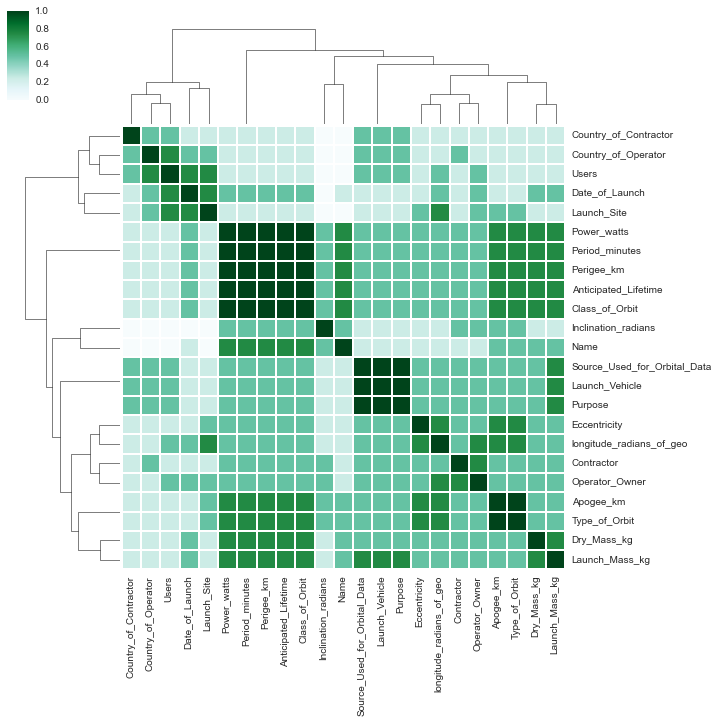

In [5]:
df = bql_utils.cursor_to_df(satellites_bdb.execute(
        'ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF satellites_cc'))
_ = plotutils.zmatrix(df)

We also register a generator that uses heuristics to guess the types of columns.

In [ ]:
generator = bayeslite.guess.bayesdb_guess_generator(satellites_bdb, 'satellites_cc', 'satellites', 'crosscat', 
                                                    ifnotexists=True)

Standard Database Functionality
====
We can use a SQLite command to list the columns in the table.

In [ ]:
pretty.pp_cursor(sys.stdout, satellites_bdb.sql_execute('PRAGMA table_info(satellites)'))

We can select data just as we would in SQL in BQL:

In [ ]:
pretty.pp_cursor(sys.stdout, satellites_bdb.execute(
        'SELECT name, dry_mass_kg, period_minutes, class_of_orbit FROM satellites LIMIT 10;'))
# TODO beautify

Visualizing the Data
=====

We can also use visualization tools packaged with BayesDB. In the next example, the first argument `dry_mass_kg` is a `NUMERICAL` variable and its conditional distribution is plotted for each value of the categorical variable `class_of_orbit`, alongside the marginal distributions.

In [ ]:
# print some of the data before it gets plotted
pretty.pp_cursor(sys.stdout, satellites_bdb.execute(
        'SELECT dry_mass_kg, class_of_orbit FROM satellites LIMIT 10'))

# TODO once fsaad is done, we won't need the dataframe
# (the plotting will take the BQL command itself)
df = bql_utils.cursor_to_df(satellites_bdb.execute(
        'SELECT dry_mass_kg, class_of_orbit FROM satellites'))
c = len(df.columns)*4
fig = plt.figure(tight_layout=True, figsize=(c, c))
gs = plotutils.pairplot(df, bdb=satellites_bdb, generator_name='satellites_cc',
                        use_shortname=None, show_contour=False,
                        colorby=None, show_missing=True, show_full=False)
plt.show()

# TODO this generates a warning message about tight_layout
# TODO The categorical variable marginal bar plot should be tranposed
# so it is aligned with the joint plot.

Inferring Missing Data
=====
Inferring is like imputing. `INFER` produces a summary value for a missing (`NULL`) entry. If we use the `EXPLICIT` keyword, we can re-infer present values.

Finally, we need to tell BayesDB which values to treat as missing, `NULL`. Different datasets use different markers for missing data, this dataset uses `NaN`. To convert all instances of `NaN` to SQL `NULL`, we use the `nullify` utility, followed by the table, followed by the value to convert to `NULL`.

In [ ]:
# TODO replace bql_utils with contrib_utils once fsaad is done
print 'total number of rows', bql_utils.cursor_to_df(satellites_bdb.execute('SELECT COUNT(*) FROM satellites;'))
print 'before nullify'
print 'NULL count', bql_utils.cursor_to_df(satellites_bdb.execute('SELECT COUNT(*) FROM satellites WHERE type_of_orbit IS NULL;'))
print 'NaN count', bql_utils.cursor_to_df(satellites_bdb.execute('SELECT COUNT(*) FROM satellites WHERE type_of_orbit IS NaN;'))
general_utils.nullify(satellites_bdb, 'satellites', float('NaN'))
print 'after nullify'
print 'NULL count', bql_utils.cursor_to_df(satellites_bdb.execute('SELECT COUNT(*) FROM satellites WHERE type_of_orbit IS NULL;'))
print 'NaN count', bql_utils.cursor_to_df(satellites_bdb.execute('SELECT COUNT(*) FROM satellites WHERE type_of_orbit IS NaN;'))
# TODO strage... need to debug this.

First we will impute missing values of `type_of_orbit`. Let us see how many values are missing.

In [ ]:
pretty.pp_cursor(sys.stdout, satellites_bdb.execute('SELECT COUNT(*) FROM satellites WHERE type_of_orbit IS NULL;'))

We will use the `INFER EXPLICIT` query to impute all missing values, and let BayesDB tell us the belief of its reported value. First we will pull out `anticipated_lifetime`, `perigee_km`, `period_minutes`, and `class_of_orbit` exactly as they appear in the table. Next we will use the special BQL expression `PREDICT <col_name> CONFIDENCE <conf_name>`, which will retrun two values: first, a prediction for `<col_name>` and second a confidence level for the predicted value.

In [ ]:
#pretty.pp_cursor(sys.stdout, satellites_bdb.execute('INFER EXPLICIT type_of_orbit WITH CONFIDENCE from satellites_cc WHERE type_of_orbit IS NULL'))
#pretty.pp_cursor(sys.stdout, satellites_bdb.execute('INFER type_of_orbit from satellites_cc'))

In [ ]:
pretty.pp_cursor(sys.stdout, satellites_bdb.execute('ESTIMATE DEPENDENCE PROBABILITY of period_minutes WITH period_minutes from satellites_cc'))

In [ ]:
satellites_bdb.execute('INFER EXPLICIT anticipated_lifetime, class_of_orbit, PREDICT type_of_orbit AS inferred_orbit_type CONFIDENCE inferred_orbit_type_conf FROM satellites_cc WHERE type_of_orbit IS NULL;')

In [ ]:
pretty.pp_cursor(sys.stdout, satellites_bdb.execute('''
CREATE TEMP TABLE inferred_orbit AS INFER EXPLICIT
        anticipated_lifetime, perigee_km, period_minutes, class_of_orbit,
        PREDICT type_of_orbit AS inferred_orbit_type
            CONFIDENCE inferred_orbit_type_conf
    FROM satellites_cc
    WHERE type_of_orbit IS NULL;'''))

In [ ]:



import bayeslite.guess
import bayeslite.crosscat
import crosscat
import crosscat.LocalEngine
from bdbcontrib.facade import do_query
from bdbcontrib import plotutils
from bdbcontrib import general_utils
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# TODO: content taken from http://probcomp-4.csail.mit.edu/bayeslite/tutorials/satellites/satellites.bql

Notice that `NaN` entires have been replaced with `None`, which is the way Python represents SQL `NULL`.

In [ ]:
c = len(df.columns)*4

fig = plt.figure(tight_layout=True, figsize=(c, c))
gs = plotutils.pairplot(df, bdb=satellites_bdb, generator_name='satellites_cc',
                        use_shortname=None, show_contour=False,
                        colorby=None, show_missing=True, show_full=False)
plt.close('all')
# use plt.show() to open a separate window where you won't get a warning about tight_layout, 
# and you will have larger plots to look at.
fig

In [ ]:
for row in satellites_bdb.execute("SELECT Name, dry_mass_kg FROM satellites LIMIT 10;"):
    print row